In [23]:
pip install -q -U tensorflow_addons keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import ipyplot as plt2
import seaborn as sns
from tensorflow.keras.datasets import mnist
import pandas as pd

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255, x_test/255
rad2deg = 180/np.pi

train_morpho = pd.read_csv("train-morpho.csv")
test_morpho = pd.read_csv("t10k-morpho.csv")
train_morpho['slant'] = train_morpho['slant'].map(lambda x: x*rad2deg)
test_morpho['slant'] = test_morpho['slant'].map(lambda x: x*rad2deg)


2023-05-29 20:47:46.530038: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Aclaracion: Transforme los slant de radianes a grados. Esto demostro arrojar mejores resultados. No crei que fuera mejor, pero parece converger mejor. Tal vez antes con los radianes tenia muy poco LR, no lo se.

# EDA

In [2]:
display(train_morpho)

,index,area,length,thickness,slant,width,height
0,0,107.3125,50.266504,2.460658,13.239592,14.539572,19.849054
1,1,123.2500,51.198485,2.616601,19.014075,15.387810,19.341053
2,2,78.3750,45.927670,1.891592,-12.157949,20.479656,19.114880
3,3,67.3125,22.849242,2.919769,29.174163,5.358179,19.724599
4,4,91.1875,46.284271,2.247425,0.434884,13.275437,19.527523
...,...,...,...,...,...,...,...
49995,49995,112.6875,49.809398,2.459659,-16.300120,12.673682,19.871024
49996,49996,94.6875,62.044679,1.760252,12.091049,18.901406,17.610015
49997,49997,92.2500,53.026912,2.049854,-7.734855,9.542894,19.697308
49998,49998,89.4375,42.927670,2.340569,1.435033,9.622476,19.306344


In [3]:
plt2.plot_class_tabs(x_train, y_train, img_width=28, show_url=False, zoom_scale=3)

## Histograma de distribucion de clases

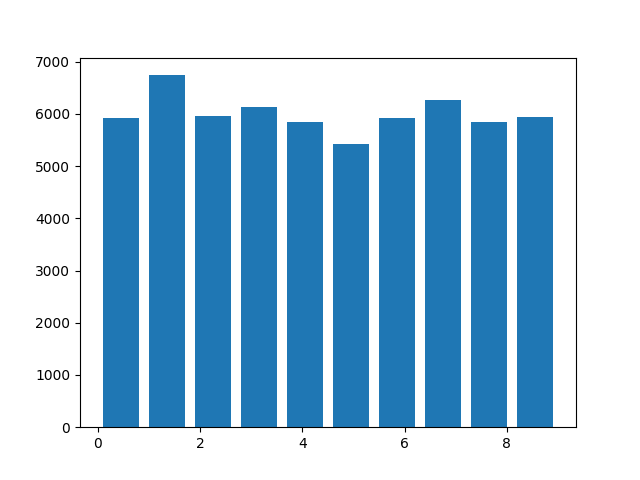

In [7]:
plt.figure()
plt.hist(y_train, rwidth=0.8)
plt.show()

## Histogramas de Slant

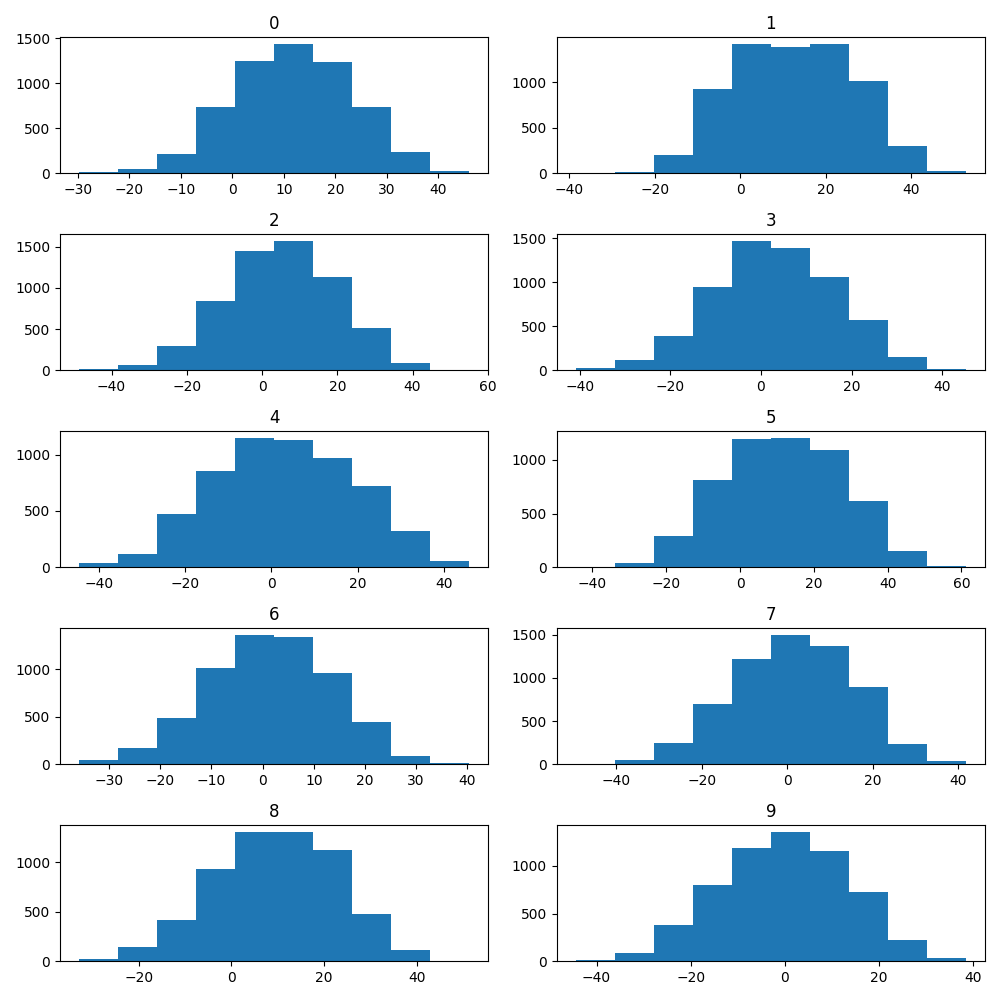

In [8]:
fig, axes = plt.subplots(5, 2, )
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_tight_layout(True)
for i in range(len(axes)):
    for j in range(len(axes[i])):
        axes[i, j].hist(train_morpho['slant'][y_train==(2*i+j)])
        axes[i,j].set_title((2*i+j))
        
plt.show()

## Graficos de violin para el slant

Como los histogramas de antes no me dieron mucho insight, hice algunos de violin a ver como quedaban. Me gustan mas estos de violin. De todas formas se ve que el slant no tiene una correlacion muy alta con la clase de la imagen, lo cual tiene sentido. 

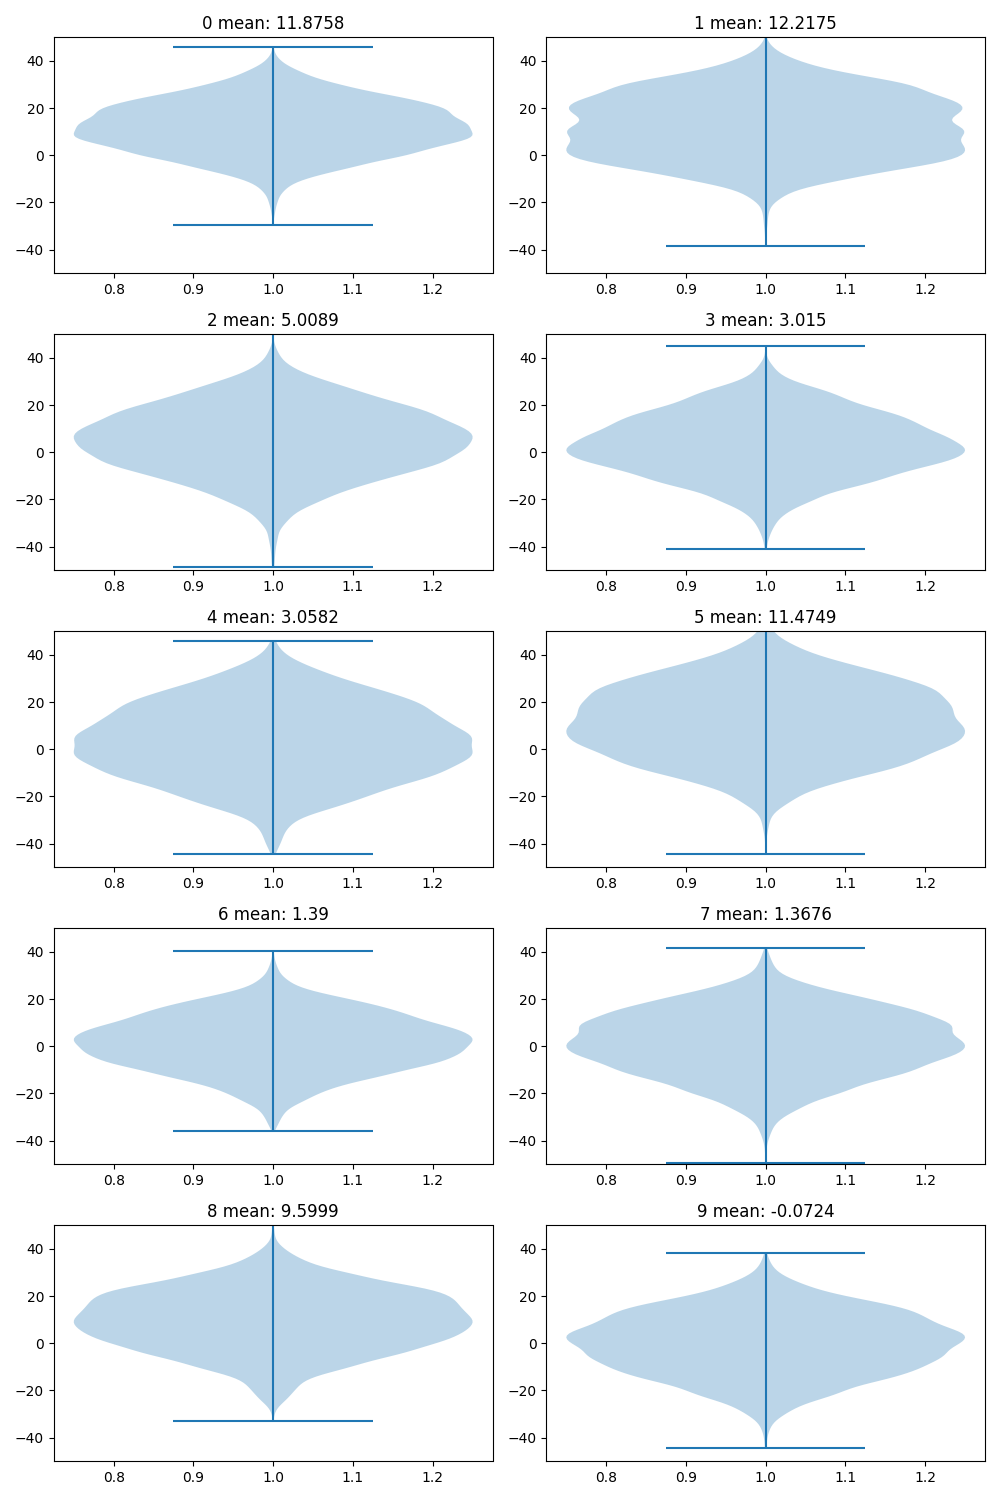

In [13]:
fig, axes = plt.subplots(5, 2, )
fig.set_figwidth(10)
fig.set_figheight(15)
fig.set_tight_layout(True)
for i in range(len(axes)):
    for j in range(len(axes[i])):
        slants = train_morpho["slant"][y_train==(2*i+j)]
        axes[i, j].violinplot(slants)
        axes[i,j].set_title(f"{2*i+j} mean: {np.round(np.mean(slants), 4)}")
        axes[i,j].set_ylim(bottom=-50, top=50)
        
plt.show()

## Media de las imagenes de cada clase

In [9]:
class_mean_x = [np.mean(x_train[y_train==i], (0)) for i in range(10)]
plt2.plot_images(class_mean_x)

Comparando con las medias de slant, se puede ver que la imagen promedio tiene un slant que a ojo parece similar al medio de la clase. Curioso.

## Matriz de correlacion de parametros morfologicos

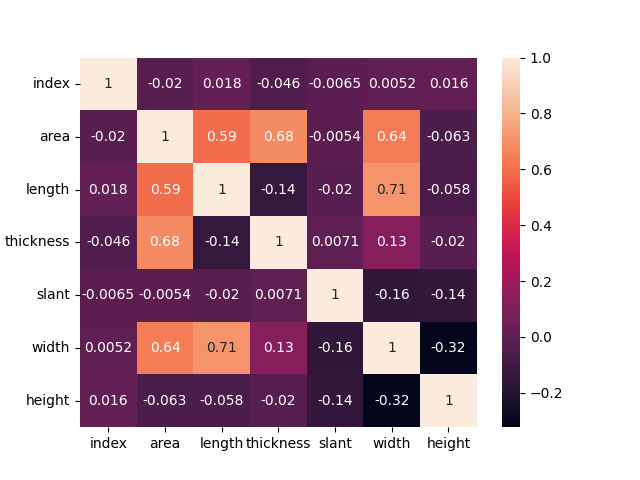

In [14]:
plt.figure()
corr_matrix = train_morpho.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

La mayor correlacion con el slant la comparte el width. De todas formas es relativamente baja, ademas de que es la correlacion lineal

# Model training

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
from helper import build_model_img
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from tensorflow.keras import optimizers as opt
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Embedding, Concatenate, Input, Normalization
from tensorflow.keras import Sequential, Model
from tensorflow_addons.optimizers import CyclicalLearningRate, Triangular2CyclicalLearningRate, TriangularCyclicalLearningRate
import keras_tuner

metrics=['mean_squared_error']

keras.utils.set_random_seed(hash("Los buenos caballos y los buenos estudiantes siempre terminan su carrera.") % 2**32)


width_mean = train_morpho["width"].mean()
width_std = train_morpho["width"].std()
if np.abs(width_mean) > 1:
    train_morpho["width"] = train_morpho["width"].apply(lambda x: (x-width_mean)/width_std)
    print(train_morpho["width"])

0        0.374996
1        0.592000
2        1.894646
3       -1.973877
4        0.051593
           ...   
59995   -0.315463
59996    0.064515
59997    0.271110
59998    0.557246
59999    0.087415
Name: width, Length: 60000, dtype: float64


/home/gullino18/anaconda3/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Como elegi el width para la parte de usar una variable continua, lo normalizo. Tambien aclaro que como la loss es el MAE, no tiene sentido pedir que reporte esa metrica ya que es el mismo numero.

Utilize un Cyclical learning rate para ver como funcionaba, y me costo setear bien los parametros. Lo use pero no pude tunearlos bien. De todas formas en algunas pruebas logre hacerlo funcionar medianamente bien, pero Adam le seguia ganando con lr fijo y callback de LROnPlateau

## Busqueda de hyperparametros con Keras Tuner

In [3]:
tuner = keras_tuner.RandomSearch(
    build_model_img,
    max_trials=25,
    # Do not resume the previous search in the same directory.
    overwrite=True,
    objective="val_loss",
    # Set a directory to store the intermediate results.
    directory="./logs/intermediates",
)

2023-05-29 20:47:52.084239: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
earlyStopCB = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
LearningSchedulerCB = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, min_lr=5e-9, patience=5)
TBsaveCB = keras.callbacks.TensorBoard("./logs")

tuner.search(
    x=x_train, y=train_morpho["slant"], batch_size=256, epochs=50, validation_data=(x_test, test_morpho["slant"]), callbacks=[earlyStopCB, LearningSchedulerCB, TBsaveCB])

Trial 25 Complete [00h 02m 23s]
val_loss: 0.24540764093399048

Best val_loss So Far: 0.07424768805503845
Total elapsed time: 00h 40m 56s
INFO:tensorflow:Oracle triggered exit


In [27]:
tuner.get_best_hyperparameters()[0].values


{'activation': 'sigmoid',
 'layers': 2,
 'lr': 0.001,
 'optimizer': 2,
 'units_0': 192,
 'dropout': False,
 'units_1': 192,
 'units_2': 192}

In [5]:
%load_ext tensorboard

In [16]:
%tensorboard --logdir "./logs"

En mi PC no me funciona en el notebook, lo abro directo en el navegador (localhost:6006)

## Modelo con entrada de imagen

In [40]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(200, activation='sigmoid'))
model.add(Dense(200, activation='sigmoid'))
model.add(Dense(200, activation='sigmoid'))
model.add(Dense(1))

clr = Triangular2CyclicalLearningRate(5e-5, 0.001, 2 * 235)

model.compile(optimizer=opt.Adam(0.001), loss='mae')
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_31 (Dense)            (None, 200)               157000    
                                                                 
 dense_32 (Dense)            (None, 200)               40200     
                                                                 
 dense_33 (Dense)            (None, 200)               40200     
                                                                 
 dense_34 (Dense)            (None, 1)                 201       
                                                                 
Total params: 237,601
Trainable params: 237,601
Non-trainable params: 0
_________________________________________________________________


In [41]:
earlyStopCB = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
LearningSchedulerCB = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, min_lr=5e-9, patience=5)

history = model.fit(x=x_train, y=train_morpho["slant"], batch_size=256, epochs=1000, validation_data=(x_test, test_morpho["slant"]), callbacks=[earlyStopCB, LearningSchedulerCB])

Epoch 1/1000
235/235 [==============================] - 3s 10ms/step - loss: 5.0059 - val_loss: 0.9832 - lr: 0.0010
Epoch 2/1000
235/235 [==============================] - 2s 8ms/step - loss: 0.7368 - val_loss: 0.4342 - lr: 0.0010
Epoch 3/1000
235/235 [==============================] - 2s 8ms/step - loss: 0.4150 - val_loss: 0.2870 - lr: 0.0010
Epoch 4/1000
235/235 [==============================] - 2s 8ms/step - loss: 0.3498 - val_loss: 0.2422 - lr: 0.0010
Epoch 5/1000
235/235 [==============================] - 2s 8ms/step - loss: 0.2726 - val_loss: 0.2043 - lr: 0.0010
Epoch 6/1000
235/235 [==============================] - 2s 8ms/step - loss: 0.2842 - val_loss: 0.2585 - lr: 0.0010
Epoch 7/1000
235/235 [==============================] - 2s 8ms/step - loss: 0.2512 - val_loss: 0.1981 - lr: 0.0010
Epoch 8/1000
235/235 [==============================] - 2s 10ms/step - loss: 0.2123 - val_loss: 0.2228 - lr: 0.0010
Epoch 9/1000
235/235 [==============================] - 2s 9ms/step - loss: 0.

MAE = 0.0609º, muy bueno la verdad

## Modelo con entrada de imagen y valor continuo

In [49]:
input_img = Input((28, 28))
input_width = Input(1,)
flatten = Flatten()(input_img)
concat = Concatenate()([flatten, input_width])
dense = Dense(200, activation='sigmoid')(concat)
dense = Dense(200, activation='sigmoid')(dense)
dense = Dense(200, activation='sigmoid')(dense)

out = Dense(1)(dense)
    
model = Model([input_img, input_width], out)

clr = Triangular2CyclicalLearningRate(5e-6, 0.001, 5 * 235)

model.compile(optimizer=opt.Adam(0.001), loss='mae')
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_13 (Flatten)           (None, 784)          0           ['input_7[0][0]']                
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 concatenate_3 (Concatenate)    (None, 785)          0           ['flatten_13[0][0]',             
                                                                  'input_8[0][0]']          

In [47]:
earlyStopCB = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0001,  restore_best_weights=True)
LearningSchedulerCB = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, min_lr=5e-9, patience=5)

history = model.fit(x=[x_train, train_morpho["width"]], y=train_morpho["slant"], batch_size=256, epochs=1000, validation_data=([x_test, test_morpho["width"]], test_morpho["slant"]), callbacks=[earlyStopCB, LearningSchedulerCB])

Epoch 1/1000
235/235 [==============================] - 3s 10ms/step - loss: 5.2479 - val_loss: 1.1059 - lr: 0.0010
Epoch 2/1000
235/235 [==============================] - 2s 9ms/step - loss: 0.7571 - val_loss: 0.7793 - lr: 0.0010
Epoch 3/1000
235/235 [==============================] - 2s 8ms/step - loss: 0.4460 - val_loss: 0.5928 - lr: 0.0010
Epoch 4/1000
235/235 [==============================] - 2s 8ms/step - loss: 0.3270 - val_loss: 0.4447 - lr: 0.0010
Epoch 5/1000
235/235 [==============================] - 2s 9ms/step - loss: 0.2771 - val_loss: 0.4616 - lr: 0.0010
Epoch 6/1000
235/235 [==============================] - 2s 9ms/step - loss: 0.2557 - val_loss: 0.4075 - lr: 0.0010
Epoch 7/1000
235/235 [==============================] - 2s 10ms/step - loss: 0.2283 - val_loss: 0.3525 - lr: 0.0010
Epoch 8/1000
235/235 [==============================] - 2s 9ms/step - loss: 0.2235 - val_loss: 0.4402 - lr: 0.0010
Epoch 9/1000
235/235 [==============================] - 2s 8ms/step - loss: 0.

Le costo mas converger y no llego tan lejos ):/

## Modelo con entrada de imagen y embeding de la label

In [50]:

input_img = Input((28, 28))
input_lbl = Input(1,)
flatten = Flatten()(input_img)
embed = Embedding(10, 2, input_length=1)(input_lbl)
embed = Flatten()(embed)
concat = Concatenate()([flatten, embed])
dense = Dense(200, activation='sigmoid')(concat)
dense = Dense(200, activation='sigmoid')(dense)
dense = Dense(200, activation='sigmoid')(dense)

out = Dense(1)(dense)
    
model = Model([input_img, input_lbl], out)

clr = Triangular2CyclicalLearningRate(1e-7, 0.001, 7 * 235)

model.compile(optimizer=opt.Adam(0.001), loss='mae')
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 2)         20          ['input_10[0][0]']               
                                                                                                  
 flatten_14 (Flatten)           (None, 784)          0           ['input_9[0][0]']                
                                                                                            

In [51]:
earlyStopCB = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
LearningSchedulerCB = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, min_lr=5e-9, patience=5)

history = model.fit(x=[x_train, y_train], y=train_morpho["slant"], batch_size=256, epochs=1000, validation_data=([x_test, y_test], test_morpho["slant"]), callbacks=[earlyStopCB, LearningSchedulerCB])

Epoch 1/1000
235/235 [==============================] - 3s 10ms/step - loss: 5.3884 - val_loss: 1.2795 - lr: 0.0010
Epoch 2/1000
235/235 [==============================] - 3s 11ms/step - loss: 0.7965 - val_loss: 0.4271 - lr: 0.0010
Epoch 3/1000
235/235 [==============================] - 2s 10ms/step - loss: 0.4317 - val_loss: 0.2892 - lr: 0.0010
Epoch 4/1000
235/235 [==============================] - 2s 9ms/step - loss: 0.3206 - val_loss: 0.2572 - lr: 0.0010
Epoch 5/1000
235/235 [==============================] - 2s 10ms/step - loss: 0.2686 - val_loss: 0.3341 - lr: 0.0010
Epoch 6/1000
235/235 [==============================] - 2s 10ms/step - loss: 0.2810 - val_loss: 0.2068 - lr: 0.0010
Epoch 7/1000
235/235 [==============================] - 2s 10ms/step - loss: 0.2226 - val_loss: 0.1916 - lr: 0.0010
Epoch 8/1000
235/235 [==============================] - 2s 10ms/step - loss: 0.2597 - val_loss: 0.2094 - lr: 0.0010
Epoch 9/1000
235/235 [==============================] - 2s 10ms/step - lo

1/1 [==============================] - 0s 59ms/step
[[-0.09009545 -0.07425555]
 [-0.07615572  0.00384629]
 [-0.04696871  0.03383636]
 [ 0.03686124  0.02219508]
 [-0.03536016  0.02346344]
 [ 0.0491651  -0.11164909]
 [-0.03253904  0.09271698]
 [-0.00937847  0.03082487]
 [ 0.04887304 -0.08178876]
 [-0.01869042  0.04659681]]


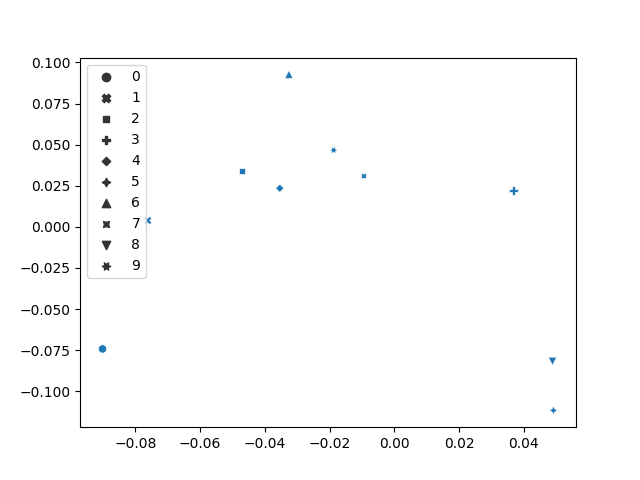

313/313 [==============================] - 1s 2ms/step
[[ 4.051683]
 [-9.987364]
 [16.572752]
 ...
 [11.185724]
 [30.442156]
 [ 7.683668]]
      index      area     length  thickness      slant      width     height
0         0   71.1875  36.256097   2.110571   4.066199  15.124338  19.620730
1         1  113.0625  43.548990   2.650075  -9.962917  17.593875  19.846226
2         2   39.2500  22.545942   1.866641  16.638250   3.679712  19.704668
3         3  146.8125  45.248737   3.480516   4.146705  14.712746  19.033061
4         4   75.2500  44.170310   1.951528  -7.378214  14.919511  18.791649
...     ...       ...        ...        ...        ...        ...        ...
9995   9995  152.8750  41.334524   3.838383  -1.446727  16.036384  19.346895
9996   9996  134.6250  45.827164   3.381650  -4.309251  14.640758  19.473707
9997   9997  114.4375  41.688077   3.254806  11.246739  11.688326  19.358837
9998   9998  104.0625  42.091883   2.651545  30.389567  15.171153  14.680493
9999   9999  1

In [52]:
aver_adentro = Model(input_lbl, embed)
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
lindo = aver_adentro.predict(labels)
print(lindo)
plt.figure()
x, y = lindo.T
sns.scatterplot(x=x, y=y, style=labels)

plt.show()
aver = model.predict([x_test, y_test/10])
print(aver)
print(test_morpho)

La verdad que el grafico del embeding no puedo sacar una conclusion muy util. Es lo que es

En general no observe una mejora muy grando de pasar la label o el parametro continuo. La label demostro ser mas util, pero para los errores tan pequeños que se obtienen solo con la imagen es dificil de mejorarlo. Ademas, en genral, la inclinacion de un numero es independiente del numero o de su tamaño, depende de quien lo escriba.